# Capstone Project - AI Detector
Author: Izzie Nielsen

### Data Importing
Importing data from Human vs. AI Generated Essays dataset

##### Steps:


*   Upload the the dataset to Colab
*   Ensure the unzip file name matches your file name
*   Unzip the file
*   Read the csv
*   Store essays and labels in a dataframe



Note: will also allow user input eventually

In [1]:
!unzip archive.zip

Archive:  archive.zip
  inflating: balanced_ai_human_prompts.csv  


In [2]:
import pandas as pd

df = pd.read_csv('/content/balanced_ai_human_prompts.csv')

display(df.head())
display(df.columns)

texts = df['text']

y = df['generated']

,text,generated
0,"Machine learning, a subset of artificial intel...",1
1,"A decision tree, a prominent machine learning ...",1
2,"Education, a cornerstone of societal progress,...",1
3,"Computers, the backbone of modern technology, ...",1
4,"Chess, a timeless game of strategy and intelle...",1


Index(['text', 'generated'], dtype='object')

### Tokenization and Text Pre-Processing

Preparing the text before inputing into the models. First, the data is split into test and training (80/20 split). Then the training and testing esssays (X) are tokenized by the BertTokenizer. SVM and BERT have different vectorization requirements.

For the BERT model:
* Save the training and testing tokens into a dataset
* Add attention mask to help the model ignore unimportant tokens
* Add labels to the dataset for supervised learning

For SVM:
* Use TF-IDF vectorization to assign values to the words
* Remove stop words

Data Augmentation:
* Both models use augmented data to improve initial poor performance
* Techniques used were word swapping, random word deletion, and random duplication





In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42)


In [4]:
import random

def simple_augmentation(text, num_aug=2):
    """
    Simple rule-based augmentation without external libraries
    """
    words = text.split()
    augmented = []

    # Original text
    augmented.append(text)

    # Method 1: Random Swap
    if num_aug >= 1 and len(words) > 3:
        new_words = words.copy()
        for _ in range(2):
            idx1, idx2 = random.sample(range(len(new_words)), 2)
            new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
        augmented.append(' '.join(new_words))

    # Method 2: Random Deletion (keep 90% of words)
    if num_aug >= 2 and len(words) > 5:
        new_words = [w for w in words if random.random() > 0.1]
        if new_words:
            augmented.append(' '.join(new_words))

    # Method 3: Random Insertion (duplicate random words)
    if num_aug >= 3 and len(words) > 3:
        new_words = words.copy()
        for _ in range(2):
            word = random.choice(words)
            pos = random.randint(0, len(new_words))
            new_words.insert(pos, word)
        augmented.append(' '.join(new_words))

    return augmented

In [5]:
def augment_training_data(texts, labels, num_aug_per_sample=2):
    """
    Augment training dataset
    """
    aug_texts = []
    aug_labels = []

    for text, label in zip(texts, labels):
        augmented = simple_augmentation(text, num_aug=num_aug_per_sample)
        aug_texts.extend(augmented)
        aug_labels.extend([label] * len(augmented))

    print(f"Original dataset: {len(texts)} samples")
    print(f"Augmented dataset: {len(aug_texts)} samples")

    return aug_texts, aug_labels


## DeBERTa V3 small Model

Why this NLP?:
* Small model with fewer parameters, allowing it can run on my laptop
* High performance
* Great speed
* Better performance with essay data than BERT

Before Running the Model:
* Ensure required libraries are installed (transformers, datasets, torch, and evauluation)
    * use pip install
* Get an API key
    * https://wandb.ai/authorize?ref=models
    * You will need to make a free account

Steps:
* Import required libraries
* Create tokenizer and model
* Tokenize training and testing data
    * Max length of 512 due to model limitations
* Create Vector DB
    * Uses a torch database
    * Attention mask to keep model focused on important parameters
* Create Training arguments
* Train the NLP on the data
* Measure metrics using F-Score

Results so far:
* F-Score = 0.9962264150943396
    * Indicates High accuracy and recall
    * High F-score indicates robust model performance

Future work:
* Not all of the essay is being evaluated due to token constraints (essay length of 800 words is more than 512 tokens), therefore I am planning on chunking the input
* Generating more performance metrics for the model
* Potentially adjusting some hyperparameters to improve performance


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
model_b = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-small", num_labels=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def get_robust_training_args():
    """
    Optimized training arguments for better OOD performance
    """
    return TrainingArguments(
        output_dir="./deberta-robust",

        # CRITICAL: Use cosine learning rate schedule
        learning_rate=2e-5,
        lr_scheduler_type="cosine",
        warmup_ratio=0.1,  # Warm up for 10% of training

        # CRITICAL: Strong regularization
        weight_decay=0.01,  # L2 regularization
        max_grad_norm=1.0,  # Gradient clipping

        # Train longer for better generalization
        num_train_epochs=5,  # Increased from 2

        # Batch size
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,

        # Evaluation
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",

        # Performance
        fp16=True,
        logging_steps=50,
    )


In [7]:
def tokenize_with_chunks(texts, tokenizer, max_length=512, stride=256):
    """
    Handle long texts by splitting into overlapping chunks
    """
    all_input_ids = []
    all_attention_masks = []
    chunk_indices = []  # Track which chunks belong to which text

    for idx, text in enumerate(texts):
        # Tokenize without truncation first
        tokens = tokenizer(text, truncation=False, return_tensors='pt')
        input_ids = tokens['input_ids'][0]

        if len(input_ids) <= max_length:
            # Short text - process normally
            result = tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=max_length,
                return_tensors='pt'
            )
            all_input_ids.append(result['input_ids'][0])
            all_attention_masks.append(result['attention_mask'][0])
            chunk_indices.append(idx)
        else:
            # Long text - create overlapping windows
            for i in range(0, len(input_ids), stride):
                chunk = input_ids[i:i + max_length]
                if len(chunk) < max_length:
                    # Pad the last chunk
                    chunk = torch.cat([
                        chunk,
                        torch.zeros(max_length - len(chunk), dtype=torch.long)
                    ])

                mask = torch.ones(max_length, dtype=torch.long)
                mask[len(input_ids[i:i + max_length]):] = 0

                all_input_ids.append(chunk)
                all_attention_masks.append(mask)
                chunk_indices.append(idx)

                # Stop if we've covered the whole text
                if i + max_length >= len(input_ids):
                    break

    return {
        'input_ids': torch.stack(all_input_ids),
        'attention_mask': torch.stack(all_attention_masks),
        'chunk_indices': chunk_indices
    }


In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import numpy as np
import evaluate

def train_ood_robust_model(X_train, y_train, X_test, y_test):
    """
    Complete training pipeline with OOD improvements
    """

    # STEP 1: Data Augmentation
    print("=" * 50)
    print("STEP 1: Augmenting training data...")
    print("=" * 50)

    X_train_aug, y_train_aug = augment_training_data(
        X_train.tolist(),
        y_train.tolist(),
        num_aug_per_sample=2
    )

    # STEP 2: Model Setup
    print("\n" + "=" * 50)
    print("STEP 2: Loading model...")
    print("=" * 50)

    # Use base model instead of small for better performance
    model_name = "microsoft/deberta-v3-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        hidden_dropout_prob=0.15,  # Increase dropout
        attention_probs_dropout_prob=0.15
    )

    # STEP 3: Tokenization
    print("\n" + "=" * 50)
    print("STEP 3: Tokenizing data...")
    print("=" * 50)

    train_encodings = tokenizer(
        X_train_aug,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors='pt'
    )

    test_encodings = tokenizer(
        X_test.tolist(),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors='pt'
    )

    # Create datasets
    train_dataset = Dataset.from_dict({
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'labels': y_train_aug
    })

    test_dataset = Dataset.from_dict({
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'labels': y_test.tolist()
    })

    # STEP 4: Training
    print("\n" + "=" * 50)
    print("STEP 4: Training model...")
    print("=" * 50)

    training_args = get_robust_training_args()

    # Import F1 metric
    metric = evaluate.load("f1")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    # Train
    trainer.train()

    # STEP 5: Evaluation
    print("\n" + "=" * 50)
    print("STEP 5: Evaluating model...")
    print("=" * 50)

    results = trainer.evaluate()
    print(f"\nTest F1 Score: {results['eval_f1']:.4f}")
    print(f"Test Loss: {results['eval_loss']:.4f}")

    return model, tokenizer, trainer

In [11]:
def test_on_ood_data(model, tokenizer, ood_texts, ood_labels):
    """
    Test model on out-of-distribution data
    """
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Tokenize OOD data
    encodings = tokenizer(
        ood_texts,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors='pt'
    )

    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Get predictions
    with torch.no_grad():
        outputs = model(
            input_ids=encodings['input_ids'].to(device),
            attention_mask=encodings['attention_mask'].to(device)
        )
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

    # Print results
    print("=" * 50)
    print("OUT-OF-DISTRIBUTION PERFORMANCE")
    print("=" * 50)
    print("\nClassification Report:")
    print(classification_report(
        ood_labels,
        predictions,
        target_names=['Human', 'AI']
    ))

    # Confusion matrix
    cm = confusion_matrix(ood_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Human', 'AI'],
                yticklabels=['Human', 'AI'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('OOD Data - Confusion Matrix')
    plt.show()

    return predictions

In [12]:
model, tokenizer, trainer = train_ood_robust_model(X_train, y_train, X_test, y_test)


STEP 1: Augmenting training data...
Original dataset: 2200 samples
Augmented dataset: 6600 samples

STEP 2: Loading model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STEP 3: Tokenizing data...

STEP 4: Training model...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: izzienielsen (izzienielsen-creighton-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1
1,0.035400,0.074584,0.976923
2,0.000000,0.041144,0.996226
3,0.000000,0.043746,0.996226
4,0.000000,0.044825,0.996226
5,0.000000,0.045017,0.996226



STEP 5: Evaluating model...



Test F1 Score: 0.9962
Test Loss: 0.0411


## SVM

1. Preprocessing
    
    * TF-IDF vectorization is used to allow the computer to understand the complex text data.

2. Model Creation

    * Create SVM model and train it using the vectorized training essays and labels for a supervised approach.
  
3. Evaulate Model Performance

    * Calculate accuracy, precision, and recall to determine performance

    * Generate Confusion Matrix

4. Evaluate for Overfitting


In [13]:
#takes tokens and assigns values
#only used by SVM
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=2000,
    min_df=2,
    max_df=0.8
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

svm_model = SVC(
    kernel='rbf',
    gamma='scale',
    C=0.1,  # Much lower C (was 1)
    probability=True
)
svm_model.fit(X_train_tfidf, y_train)

SVC(C=0.1, probability=True)

## Ensemble Model Creation
### Steps:
* Initialize labels
* Ensure text is in the proper format
* Get SVM and DeBERTa predictions
* Calculate a weighted average

In [23]:
LABELS = ["Human-written", "AI-written"]

def ensemble_predict(texts, svm_model, vectorizer, tokenizer, model, alpha=0.5):
    import torch
    import numpy as np

    # Ensure texts is a list
    if isinstance(texts, str):
        texts = [texts]

    # SVM prediction
    X_tfidf = vectorizer.transform(texts)
    svm_proba = svm_model.predict_proba(X_tfidf)

    # DeBERTa prediction
    tokens = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(
            input_ids=tokens['input_ids'].to(device),
            attention_mask=tokens['attention_mask'].to(device)
        )
        bert_proba = torch.softmax(outputs.logits, dim=1).cpu().numpy()

    # Weighted average
    final_proba = alpha * svm_proba + (1 - alpha) * bert_proba
    preds = np.argmax(final_proba, axis=1)

    return preds, svm_proba, bert_proba, final_proba

## Gradio Front End Creation
* Ensure text is entered
* Formatting output
* Handle errors
* Use gradio library to create front end

In [24]:
def gradio_predict(text):
    try:
        if not text or len(text.strip()) == 0:
            return {"error": "Please enter some text to analyze"}

        preds, svm_proba, bert_proba, final_proba = ensemble_predict(
            text, svm_model, vectorizer, tokenizer, model, alpha=0.5
        )

        output = {
            "Ensemble Prediction": LABELS[preds[0]],
            "Ensemble Probabilities": {
                "Human": float(final_proba[0][0]),
                "AI": float(final_proba[0][1]),
            },
            "SVM Probabilities": {
                "Human": float(svm_proba[0][0]),
                "AI": float(svm_proba[0][1]),
            },
            "DeBERTa Probabilities": {
                "Human": float(bert_proba[0][0]),
                "AI": float(bert_proba[0][1]),
            }
        }
        return output
    except Exception as e:
        return {"error": f"An error occurred: {str(e)}"}

# Launch Gradio interface
import gradio as gr

demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=10, placeholder="Paste essay text here...", label="Essay Text"),
    outputs=gr.JSON(label="Prediction Details"),
    title="AI Writing Detector (SVM + DeBERTa Ensemble)",
    description="Probability-averaged ensemble combining TF-IDF SVM and DeBERTa.",
    examples=[
        ["sample essay"]
    ]
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://af5dca48e15309fb25.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Explainability

In [35]:
import torch
class SimpleExplainer:
    """explainer for Gradio interface with error handling"""

    def __init__(self, model, tokenizer, device=None):
        self.model = model
        self.tokenizer = tokenizer

        # detect device
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)

        print(f"Using device: {self.device}")
        self.model.eval()
        self.model.to(self.device)

    def predict(self, text):
        """get prediction"""
        try:
            # clean text
            text = text.strip()
            if not text:
                return 0, 0.5, np.array([0.5, 0.5])

            inputs = self.tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=512
            )

            # move to correct device
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model(**inputs)
                probs = torch.softmax(outputs.logits, dim=1)
                pred = torch.argmax(probs, dim=1).item()
                confidence = probs[0][pred].item()

            return pred, confidence, probs[0].cpu().numpy()

        except Exception as e:
            print(f"Error in predict: {e}")
            import traceback
            traceback.print_exc()
            return 0, 0.5, np.array([0.5, 0.5])

    def find_important_words(self, text, top_k=10):
        """find most important words with error handling"""
        try:
            original_pred, original_conf, _ = self.predict(text)
            words = text.split()

            if len(words) > 200:
                words = words[:200]
                text = ' '.join(words)

            word_importance = []

            for i, word in enumerate(words):
                # skip very short words
                if len(word) <= 2:
                    continue

                # create text without this word
                modified_text = ' '.join(words[:i] + words[i+1:])

                # skip if modified text is too short
                if len(modified_text.strip()) < 10:
                    continue

                new_pred, new_conf, _ = self.predict(modified_text)

                # calculate importance
                importance = abs(original_conf - new_conf)

                # bonus if prediction flips
                if new_pred != original_pred:
                    importance += 0.5

                word_importance.append({
                    'word': word,
                    'position': i,
                    'importance': importance
                })

            # sort by importance
            word_importance.sort(key=lambda x: x['importance'], reverse=True)

            return word_importance[:top_k]

        except Exception as e:
            print(f"Error in find_important_words: {e}")
            import traceback
            traceback.print_exc()
            return []

    def generate_counterfactual(self, text):
        """Generate simple counterfactual with error handling"""
        try:
            original_pred, original_conf, _ = self.predict(text)
            target_class = 1 - original_pred

            words = text.split()

            # limit for performance
            if len(words) > 150:
                return None

            # remove each word
            for i in range(len(words)):
                if len(words[i]) <= 2:  # Skip short words
                    continue

                modified_text = ' '.join(words[:i] + words[i+1:])

                # skip if too short
                if len(modified_text.strip()) < 10:
                    continue

                new_pred, new_conf, _ = self.predict(modified_text)

                if new_pred == target_class:
                    return {
                        'original': text,
                        'counterfactual': modified_text,
                        'original_pred': 'AI-written' if original_pred == 1 else 'Human-written',
                        'cf_pred': 'AI-written' if new_pred == 1 else 'Human-written',
                        'word_removed': words[i],
                        'position': i
                    }

            return None

        except Exception as e:
            print(f"Error in generate_counterfactual: {e}")
            import traceback
            traceback.print_exc()
            return None

In [42]:
def create_explainable_interface(model, tokenizer):
    """
    gradio interface with explanations
    """

    explainer = SimpleExplainer(model, tokenizer)

    def predict_with_explanation(text):
        """main prediction function with explanations and error handling"""

        try:
            # check input
            if not text or len(text.strip()) < 5:
                return (
                    {"Error": "Text too short. Please enter at least 5 characters."},
                    "<p>No analysis available</p>",
                    pd.DataFrame(),
                    "Text too short for analysis"
                )

            # get prediction
            print("Getting prediction...")
            pred, conf, probs = explainer.predict(text)

            # prediction output
            prediction_output = {
                "Prediction": "AI-written" if pred == 1 else "Human-written",
                "Confidence": f"{conf:.1%}",
                "AI Probability": f"{probs[1]:.1%}",
                "Human Probability": f"{probs[0]:.1%}"
            }

            # find important words
            print("Finding important words...")
            important_words = explainer.find_important_words(text, top_k=10)

            # highlight text
            if important_words:
                words = text.split()
                important_word_set = {item['word'] for item in important_words[:5]}

                highlighted_html = "<div style='line-height: 2; font-size: 16px;'>"
                for word in words:
                    if word in important_word_set:
                        # Find importance score
                        importance = next(
                            (item['importance'] for item in important_words if item['word'] == word),
                            0
                        )
                        # Color intensity based on importance
                        intensity = min(255, int(importance * 200))
                        color = f"rgb(255, {255-intensity}, {255-intensity})"
                        highlighted_html += f"<span style='background-color: {color}; padding: 2px; margin: 1px;'>{word}</span> "
                    else:
                        highlighted_html += f"{word} "
                highlighted_html += "</div>"
            else:
                highlighted_html = "<p>No important words identified</p>"

            # importance table
            if important_words:
                importance_df = pd.DataFrame([
                    {
                        'Word': item['word'],
                        'Importance': f"{item['importance']:.3f}",
                        'Position': item['position']
                    }
                    for item in important_words
                ])
            else:
                importance_df = pd.DataFrame()

            # Try to generate counterfactual
            print("Generating counterfactual...")
            cf = explainer.generate_counterfactual(text)

            if cf:
                counterfactual_text = f"""
 **Counterfactual Found!**

**Original Prediction:** {cf['original_pred']}
**Counterfactual Prediction:** {cf['cf_pred']}

**Explanation:**
Removing the word **"{cf['word_removed']}"** at position {cf['position']}
changes the prediction from {cf['original_pred']} to {cf['cf_pred']}.

**Original Text:**
{cf['original']}

**Counterfactual Text:**
{cf['counterfactual']}

This shows that the word "{cf['word_removed']}" is critical for the classification.
"""
            else:
                counterfactual_text = """
 **No Simple Counterfactual Found**

The model's prediction is robust, no single word removal changes the classification.
This suggests the model is considering the overall writing style and structure,
not just individual words.

**Interpretation:**
- Multiple features contribute to the prediction
- The text has a consistent style throughout
- Consider analyzing phrases or sentence structures
"""

            return prediction_output, highlighted_html, importance_df, counterfactual_text

        except Exception as e:
            print(f"Error in predict_with_explanation: {e}")
            import traceback
            traceback.print_exc()

            return (
                {"Error": f"An error occurred: {str(e)}"},
                "<p>Error during analysis</p>",
                pd.DataFrame(),
                f"Error: {str(e)}"
            )

    # Create Gradio interface
    with gr.Blocks(title="AI Text Detector with Explanations") as demo:

        gr.Markdown("""
        # AI Text Detection with Explainability

        This tool not only detects AI-generated text but also **explains why** it made that decision.

        ### Features:
        - **Prediction**: Classify text as AI or Human-written
        - **Word Importance**: See which words matter most
        - **Counterfactual Explanation**: Understand what would change the prediction
        """)

        with gr.Row():
            with gr.Column():
                input_text = gr.Textbox(
                    lines=10,
                    placeholder="Paste your text here...",
                    label="Input Text"
                )

                analyze_btn = gr.Button("Analyze Text", variant="primary")
                gr.ClearButton(components=[input_text])

                gr.Markdown("""
                ### Tips:
                - Longer texts (100+ words) give better explanations
                - The analysis can take up to 30 seconds
                - Red highlights = most important words
                """)

            with gr.Column():
                prediction_output = gr.JSON(label="Prediction Results")

        with gr.Row():
            highlighted_output = gr.HTML(label="Highlighted Text (Important Words)")

        with gr.Row():
            importance_table = gr.Dataframe(
                label="Word Importance Ranking",
                headers=['Word', 'Importance', 'Position']
            )

        with gr.Row():
            counterfactual_output = gr.Markdown(label="Counterfactual Explanation")

        # example essays
        gr.Markdown("### Try These Examples:")

        examples = [
            ["""The digital revolution promised a world of liberation, yet it has delivered
            a culture defined by constant tethering. In the twenty-first century, the phrase “always-on”
            is not just a technological descriptor; it is a way of life, enforced by smartphones, social media,
            and ubiquitous Wi-Fi. This omnipresent connectivity presents a profound paradox: while technology
            grants us unparalleled access to information and to one another, it simultaneously erodes the very
            boundaries necessary for mental clarity, focused attention, and genuine human presence."""],

            ["""The importance of water for data center functioning makes Wisconsin an optimal
            location for data centers. Recently, Microsoft began building a data center in Mount Pleasant,
            roughly an hour outside of Milwaukee. The facility is projected to use 2.8 million gallons of
            water in 2026, and those amounts will climb as they expand the data center. After “seven months and a lawsuit”
            the city finally released documentation, demonstrating a potential unwillingness to be transparent (Torres & Looby 2025).
            Furthermore, “fewer than one-third” of companies track their data center water usage,
            and many “sign nondisclosure agreements with local governments on water use” (Kleiber 2025).
            This lack of government and company transparency makes learning about the effects a data center
            can have difficult for communities. Data centers can have devastating effects on the surrounding
            community and environment, as well as on the Great Lakes."""],
        ]

        gr.Examples(
            examples=examples,
            inputs=input_text
        )

        analyze_btn.click(
            fn=predict_with_explanation,
            inputs=input_text,
            outputs=[prediction_output, highlighted_output, importance_table, counterfactual_output]
        )


    return demo


In [43]:
def add_explanations_to_existing_gradio(svm_model, vectorizer, bert_model, tokenizer):
    """
    Enhanced version of your existing ensemble predictor with explanations
    """

    explainer = SimpleExplainer(bert_model, tokenizer)

    def enhanced_predict(text):
        # existing ensemble prediction
        from sklearn.feature_extraction.text import TfidfVectorizer

        # SVM prediction
        X_tfidf = vectorizer.transform([text])
        svm_proba = svm_model.predict_proba(X_tfidf)

        # DeBERTa prediction
        bert_pred, bert_conf, bert_proba = explainer.predict(text)

        # ensemble (weighted average)
        alpha = 0.5
        final_proba = alpha * svm_proba + (1 - alpha) * bert_proba.reshape(1, -1)
        final_pred = np.argmax(final_proba, axis=1)[0]

        # explanation
        important_words = explainer.find_important_words(text, top_k=5)

        # output
        output = {
            "Ensemble Prediction": "AI-written" if final_pred == 1 else "Human-written",
            "Ensemble Confidence": f"{final_proba[0][final_pred]:.1%}",
            "SVM Probability (AI)": f"{svm_proba[0][1]:.1%}",
            "BERT Probability (AI)": f"{bert_proba[1]:.1%}",
            "Top Important Words": [item['word'] for item in important_words]
        }

        return output

    return enhanced_predict

In [44]:
demo = create_explainable_interface(model, tokenizer)
demo.launch(share=True)

Using device: cuda
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3a0fac27c5110e4f20.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [33]:
!pip install torch

## Code Used in SVM Development Process
* Grid search for SVM to determine the best parameters
* SVM accuracy metrics: confusion matrix, accuracy, precision, and recall

In [ ]:
# grid search to determine the best hyper parameters
# ensures more generalization
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10],
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'linear']}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train_tfidf, y_train)

print(f"Best parameters:\n{grid_search.best_params_}")

best_model = grid_search.best_estimator_


Best parameters:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


y_pred = svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9963636363636363
Precision: 1.0
Recall: 0.9924812030075187


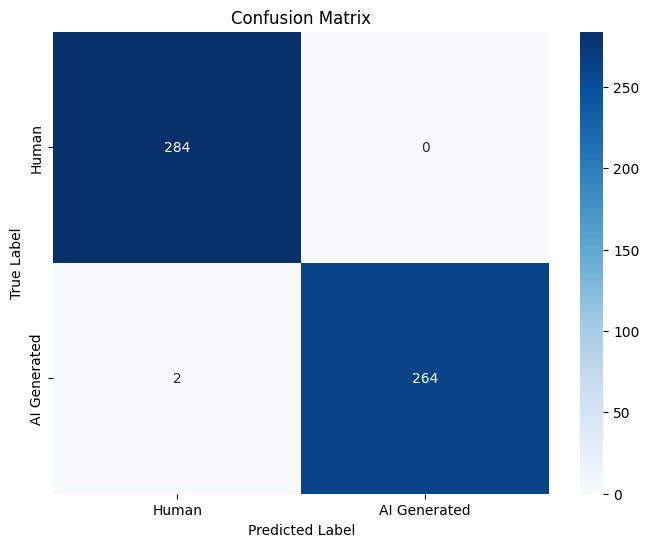

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI Generated'], yticklabels=['Human', 'AI Generated'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## K-fold Validation
* Model metrics were initially high, indicating potential overfitting
* K-fold validation was complete for both models to test
* K-fold validation did not indicate overfitting
* Note: less epochs were used on the DeBERTa because of limited computation speed

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []

for train_index, test_index in kf.split(texts):
    X_train_fold, X_test_fold = texts.iloc[train_index], texts.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    vectorizer_fold = TfidfVectorizer(
        ngram_range=(1,2),
        max_features=5000
    )
    X_train_tfidf_fold = vectorizer_fold.fit_transform(X_train_fold)
    X_test_tfidf_fold = vectorizer_fold.transform(X_test_fold)


    # initialize and train SVM model for the current fold
    model = SVC(kernel='rbf', gamma = 'scale', C=1)
    model.fit(X_train_tfidf_fold, y_train_fold)

    # make predictions and calculate accuracy
    predictions = model.predict(X_test_tfidf_fold)
    acc = accuracy_score(y_test_fold, predictions)
    accuracies.append(acc)

print("Accuracy scores for each fold:", accuracies)
print("Mean accuracy:", np.mean(accuracies))

Accuracy scores for each fold: [0.9963636363636363, 1.0, 1.0, 0.9981818181818182, 1.0]
Mean accuracy: 0.9989090909090909


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import numpy as np

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_features=5000
    )),
    ('svm', LinearSVC())
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, texts, y, cv=skf, scoring='accuracy')

print("Accuracy per fold:", scores)
print("Mean accuracy:", np.mean(scores))


Accuracy per fold: [0.99818182 1.         0.99818182 1.         0.99818182]
Mean accuracy: 0.9989090909090909


In [ ]:
import evaluate
from sklearn.model_selection import KFold
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import numpy as np

def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=512
    )

kf = KFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
fold = 1

for train_index, test_index in kf.split(texts):
    print(f"\n===== Fold {fold} =====")

    X_train_fold, X_test_fold = texts.iloc[train_index], texts.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
    model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-small", num_labels=2)

    train_tokens = tokenize_texts(X_train_fold.tolist())
    test_tokens  = tokenize_texts(X_test_fold.tolist())

    train_dataset = Dataset.from_dict({
        "input_ids": train_tokens["input_ids"],
        "attention_mask": train_tokens["attention_mask"],
        "labels": y_train_fold.tolist()
    })

    test_dataset = Dataset.from_dict({
        "input_ids": test_tokens["input_ids"],
        "attention_mask": test_tokens["attention_mask"],
        "labels": y_test_fold.tolist()
    })

    metric = evaluate.load("f1")
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    training_args = TrainingArguments(
        output_dir=f"./deberta_fold_{fold}",
        eval_strategy="epoch",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=2e-5,
        logging_steps=20,
        save_strategy="no",
        load_best_model_at_end=False
    )

    trainer = Trainer(
        model=model_b,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # evaluate
    metrics = trainer.evaluate()
    current_f1 = metrics["eval_f1"]
    print(f"Fold {fold} F1 Score: {current_f1}")
    f1_scores.append(current_f1)
    fold += 1

print("\nF1 Scores for each fold:", f1_scores)
print("Mean F1 Score:", np.mean(f1_scores))
print("Standard deviation of F1 Scores:", np.std(f1_scores))


===== Fold 1 =====


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.000400,0.029352,0.996226
2,0.000200,0.032151,0.996226
3,0.000100,0.032916,0.996226


Fold 1 F1 Score: 0.9962264150943396

===== Fold 2 =====


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.000300,0.000129,1.000000
2,0.000300,0.000139,1.000000
3,0.000200,0.000109,1.000000


Fold 2 F1 Score: 1.0

===== Fold 3 =====


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.051600,0.000243,1.000000
2,0.046300,0.000241,1.000000
3,0.027600,0.000129,1.000000


Fold 3 F1 Score: 1.0

===== Fold 4 =====


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.000400,0.015765,0.998172
2,0.000300,0.015838,0.998172
3,0.000200,0.015386,0.998172


Fold 4 F1 Score: 0.9981718464351006

===== Fold 5 =====


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.000600,0.000209,1.000000
2,0.000300,0.000131,1.000000
3,0.000300,0.000141,1.000000


Fold 5 F1 Score: 1.0

F1 Scores for each fold: [0.9962264150943396, 1.0, 1.0, 0.9981718464351006, 1.0]
Mean F1 Score: 0.998879652305888
Standard deviation of F1 Scores: 0.0015037415814276298
